In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 18,8


In [33]:
  timeseries = pd.read_excel('Airlines+Data.xlsx',index_col=[0])
  timeseries

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


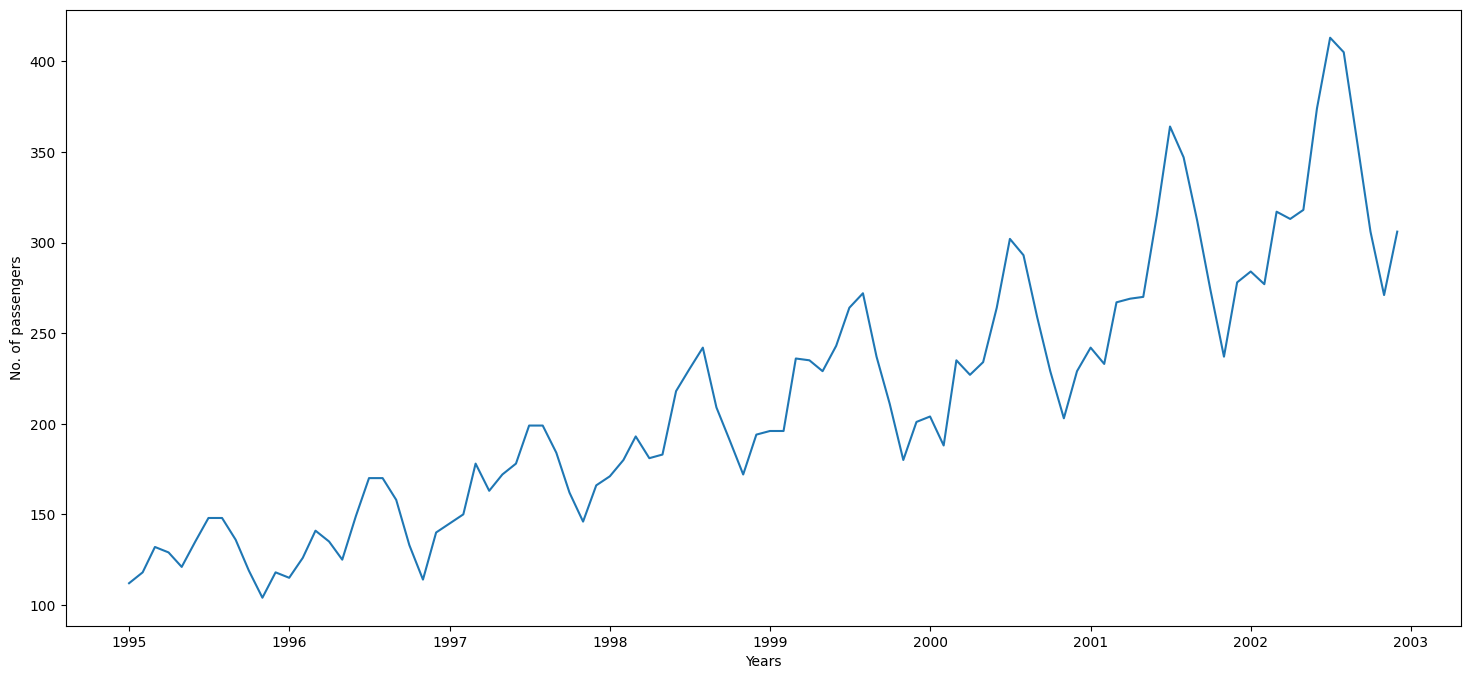

In [34]:
plt.plot(timeseries)
plt.ylabel('No. of passengers')
plt.xlabel('Years');

In [35]:
from statsmodels.tsa.stattools import adfuller,acf,pacf

<Axes: title={'center': 'Seasonarity of the Time Series'}, xlabel='Month', ylabel='Passengers'>

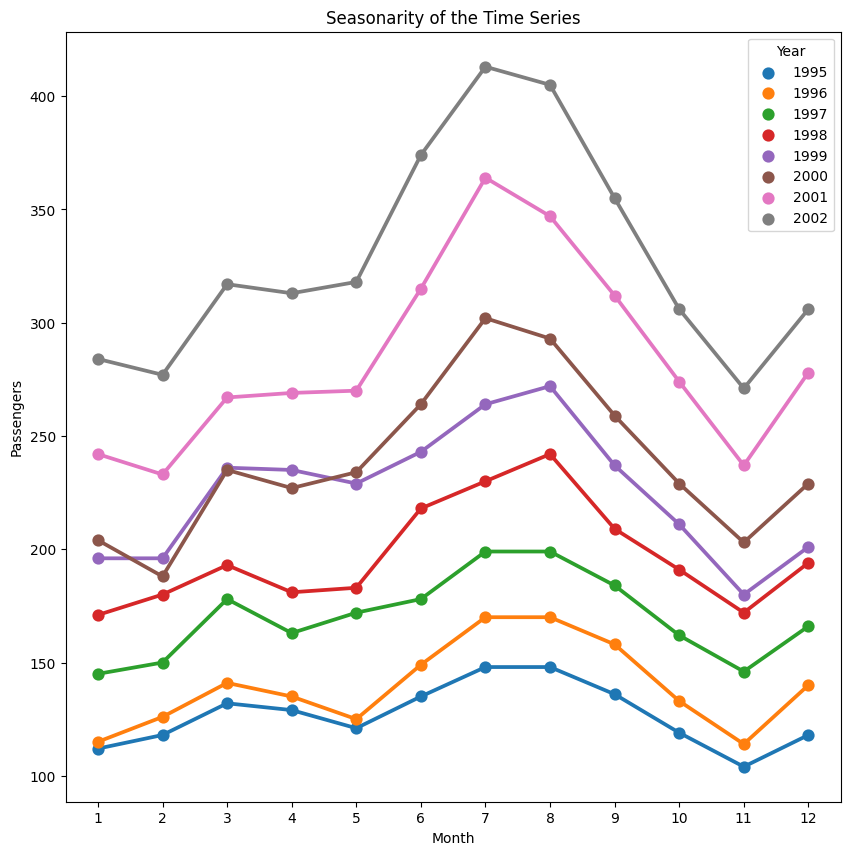

In [36]:
df_temp = timeseries.copy()
df_temp['Year'] = pd.DatetimeIndex(df_temp.index).year
df_temp['Month'] = pd.DatetimeIndex(df_temp.index).month

plt.figure(figsize=(10,10))
plt.title('Seasonarity of the Time Series')
sns.pointplot(x='Month',y='Passengers',hue='Year',data = df_temp)

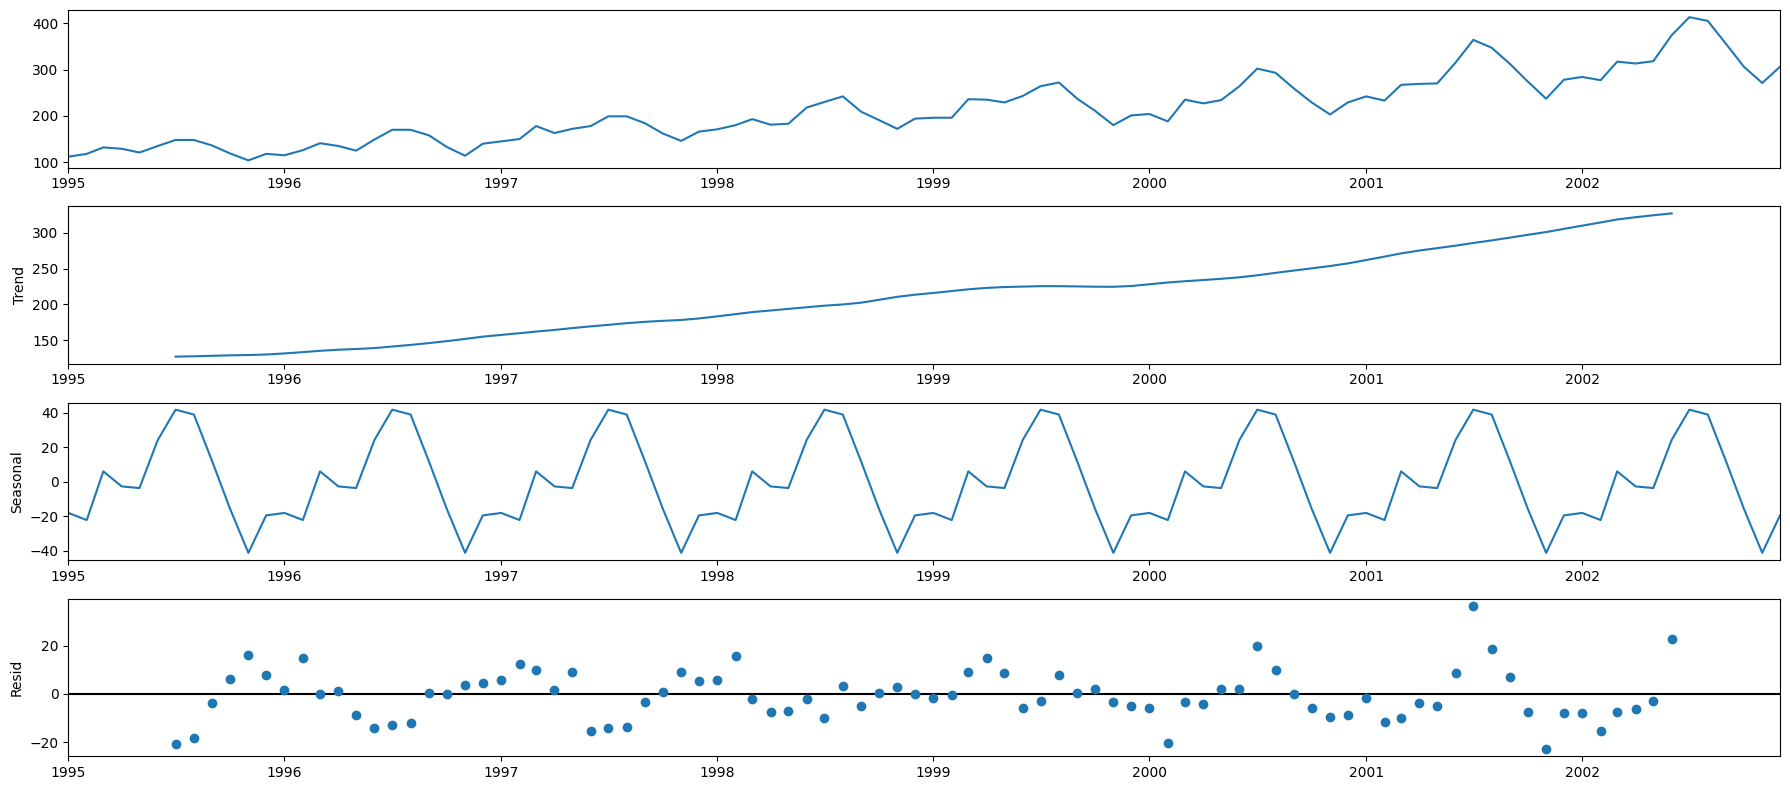

In [37]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(timeseries,model='additive')
fig = decomposition.plot()

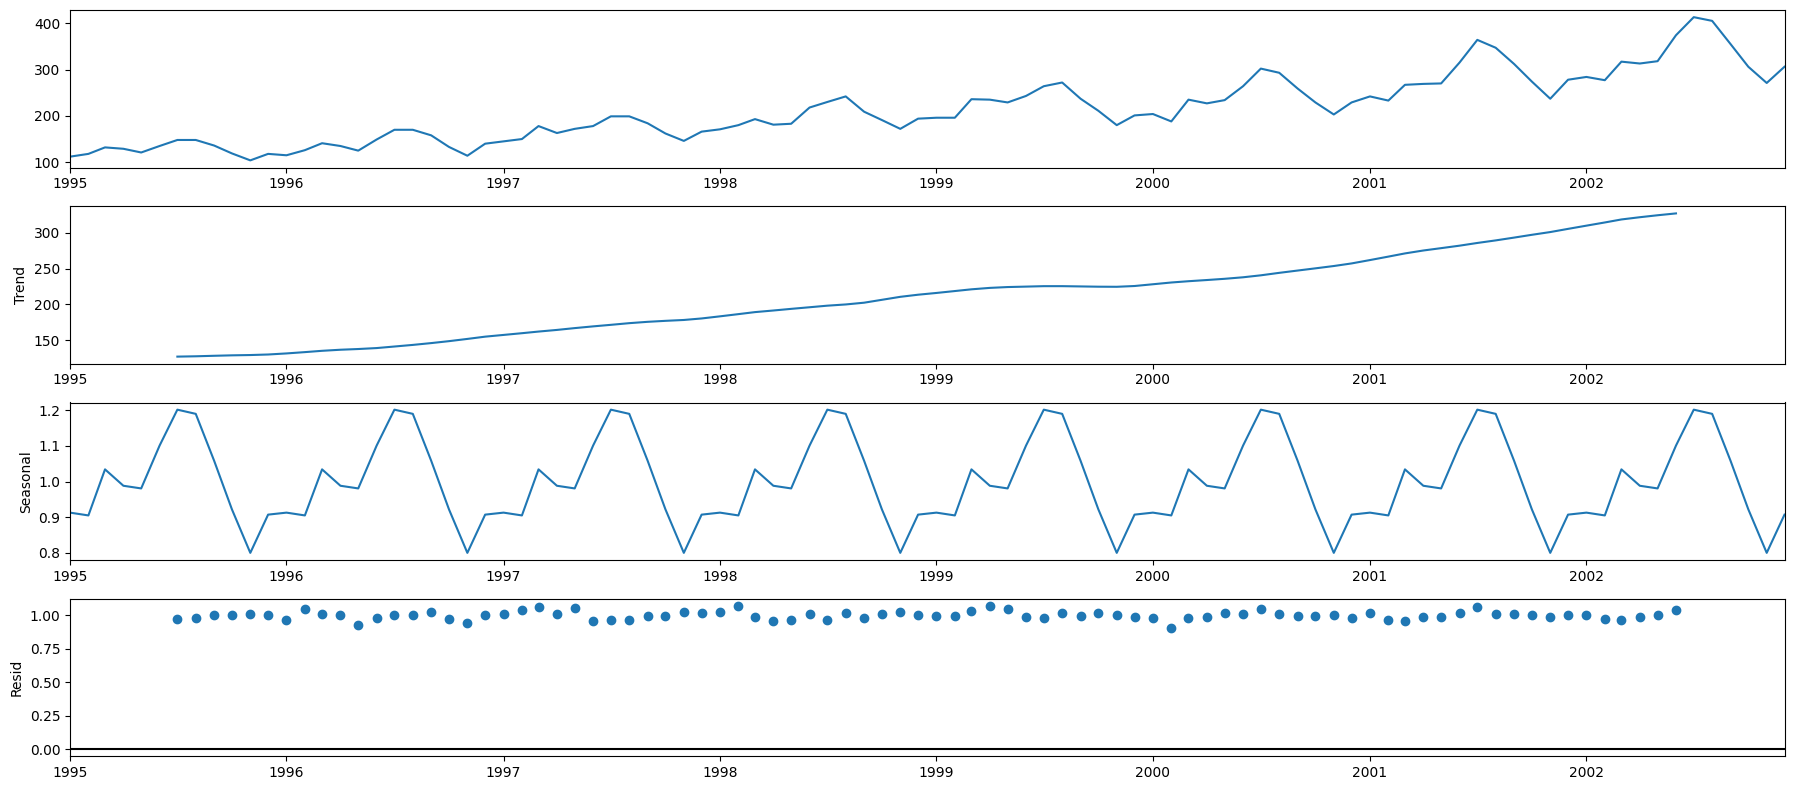

In [38]:
import statsmodels.api as sm

decomposition_mul = sm.tsa.seasonal_decompose(timeseries,model='multiplicative')
fig = decomposition_mul.plot()

Results of Dickey-Filler Test
Test Statistic                  1.340248
p-value                         0.996825
#Lags used                     12.000000
Number of Observations Used    83.000000
Critical value (1%)            -3.511712
Critical value (5%)            -2.897048
Critical value (10%)           -2.585713
dtype: float64




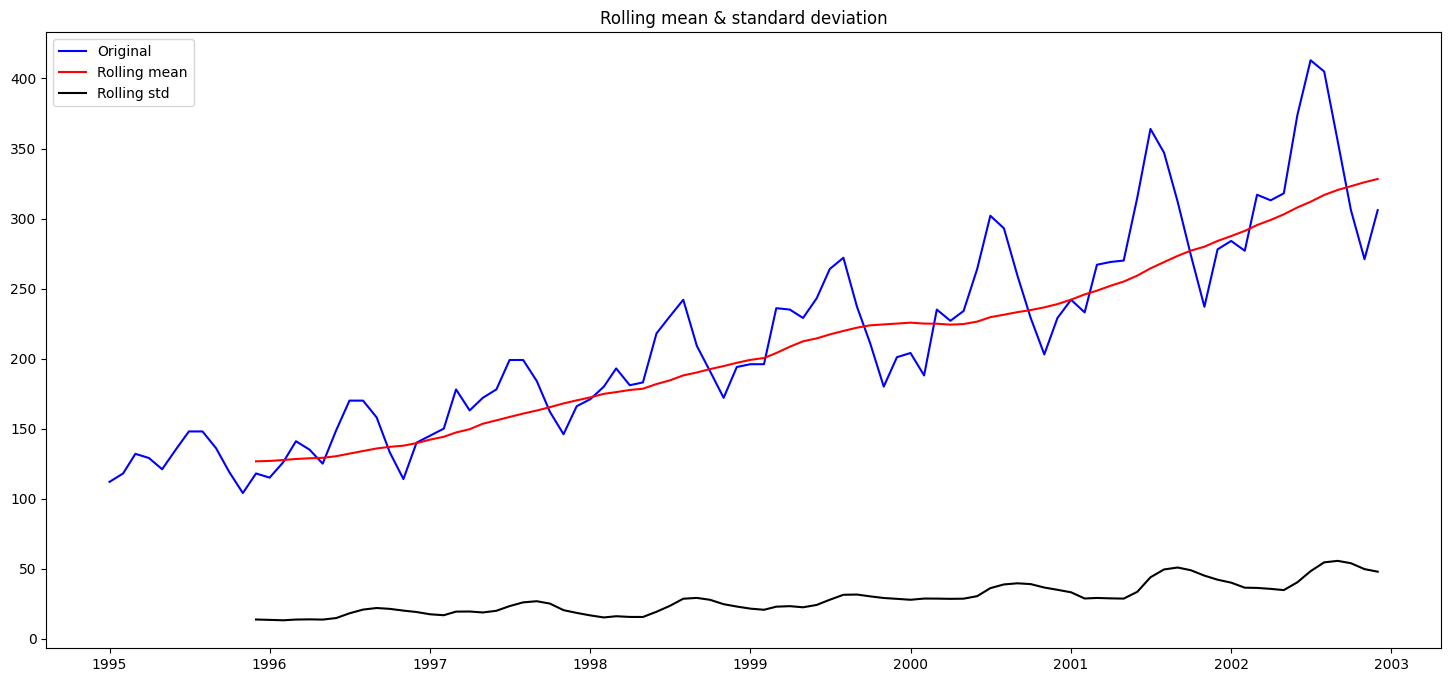

In [39]:
from statsmodels.tsa.stattools import adfuller,acf,pacf

def roll_mean(x):

  rollmean = x.rolling(window=12).mean()

  rollstd = x.rolling(window=12).std()
  plt.plot(x,color='blue',label='Original')
  plt.plot(rollmean,color='red',label='Rolling mean')
  plt.plot(rollstd,color='black',label='Rolling std')
  plt.legend(loc='best')
  plt.title('Rolling mean & standard deviation')

  print('Results of Dickey-Filler Test')
  df_test = adfuller(x)
  df_output = pd.Series(df_test[0:4],index= ['Test Statistic','p-value','#Lags used','Number of Observations Used'])

  for key,value in df_test[4].items():
    df_output['Critical value (%s)' %key] = value
  print(df_output)
  print('\n')

roll_mean(timeseries)

Results of Dickey-Filler Test
Test Statistic                 -0.723027
p-value                         0.840695
#Lags used                     12.000000
Number of Observations Used    83.000000
Critical value (1%)            -3.511712
Critical value (5%)            -2.897048
Critical value (10%)           -2.585713
dtype: float64




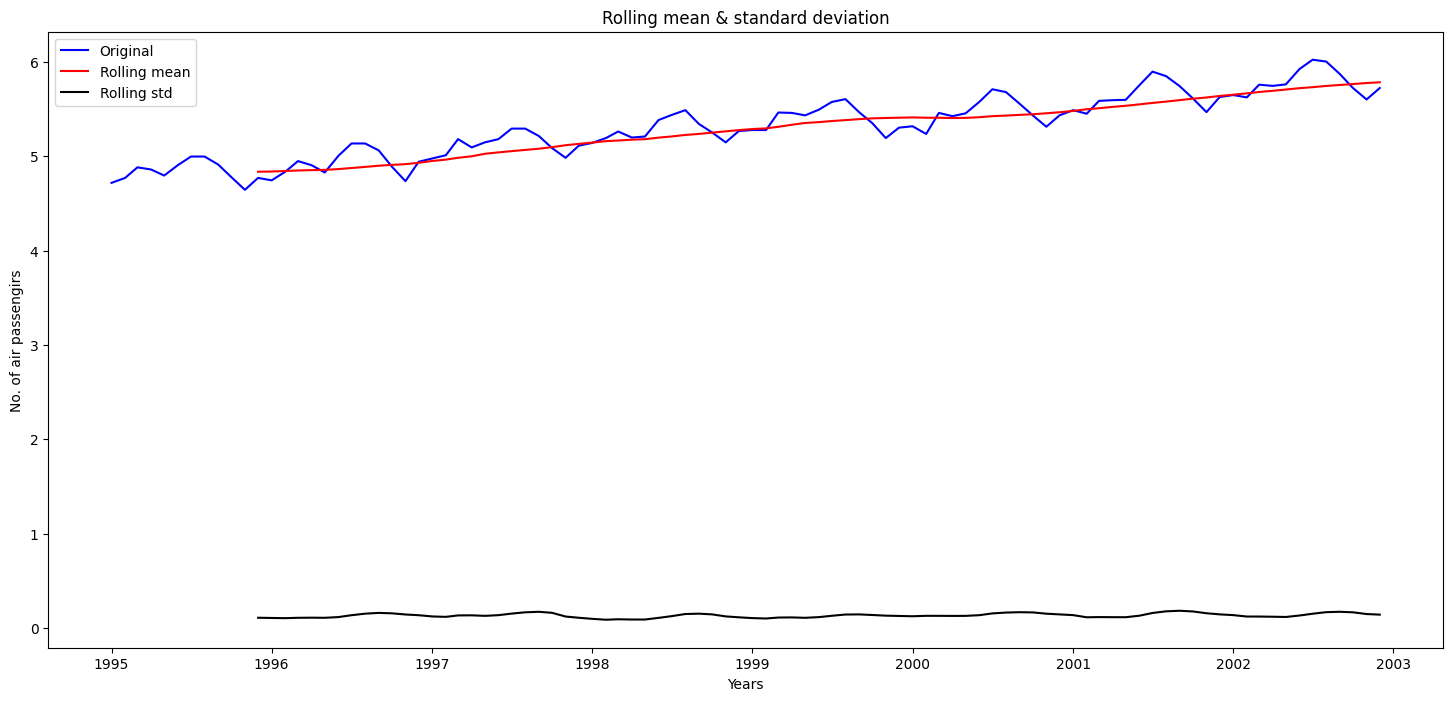

In [40]:
# Convert Non-Stationary data to Stattionary data
df_log = np.log(timeseries)

df_log.dropna(inplace=True)

plt.xlabel('Years')
plt.ylabel('No. of air passengirs')
plt.title('Convert Non-stationary data to stationary using log')
roll_mean(df_log)

In [41]:
movingAverage = df_log.rolling(window=12).mean()


In [42]:
dataLogScaleMinusMovingAvg = df_log - movingAverage
dataLogScaleMinusMovingAvg.dropna(inplace=True)

Results of Dickey-Filler Test
Test Statistic                 -1.910930
p-value                         0.326937
#Lags used                     12.000000
Number of Observations Used    72.000000
Critical value (1%)            -3.524624
Critical value (5%)            -2.902607
Critical value (10%)           -2.588679
dtype: float64




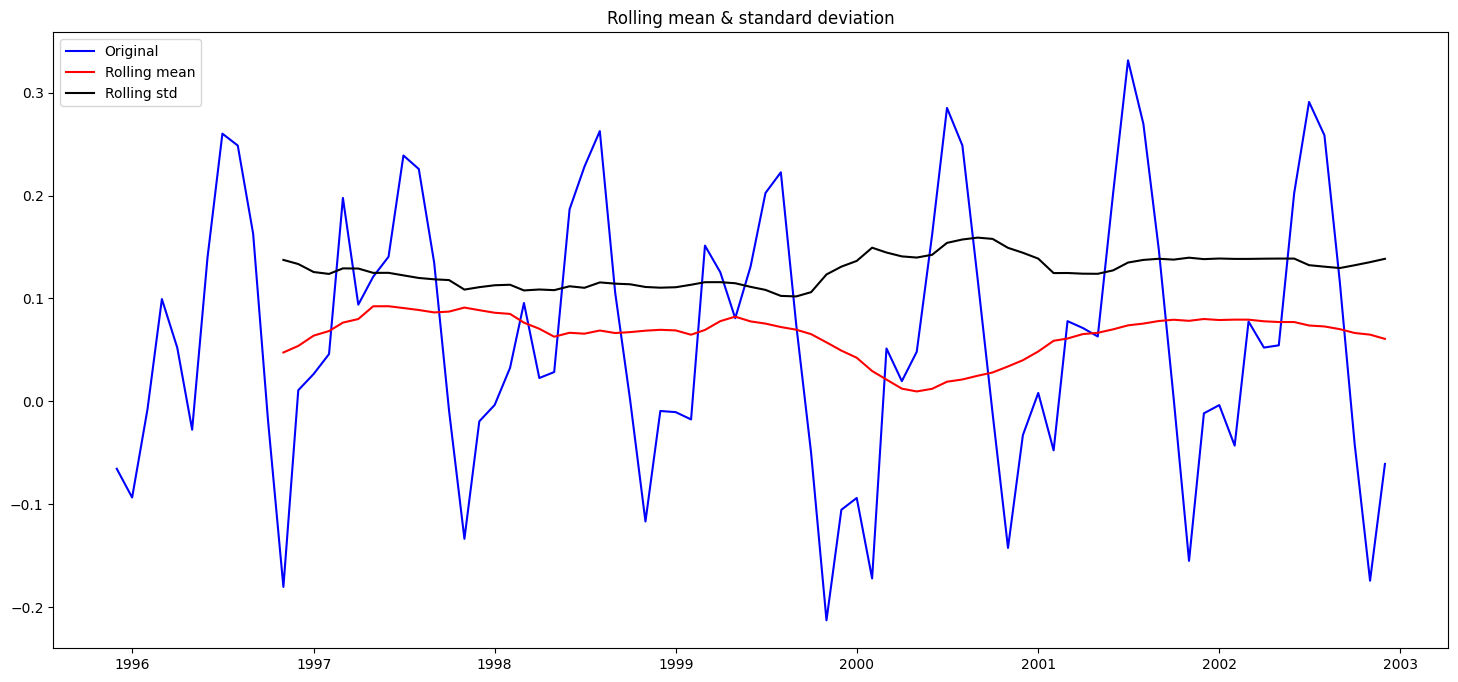

In [43]:
roll_mean(dataLogScaleMinusMovingAvg)

Results of Dickey-Filler Test
Test Statistic                 -0.135091
p-value                         0.945829
#Lags used                     12.000000
Number of Observations Used    83.000000
Critical value (1%)            -3.511712
Critical value (5%)            -2.897048
Critical value (10%)           -2.585713
dtype: float64




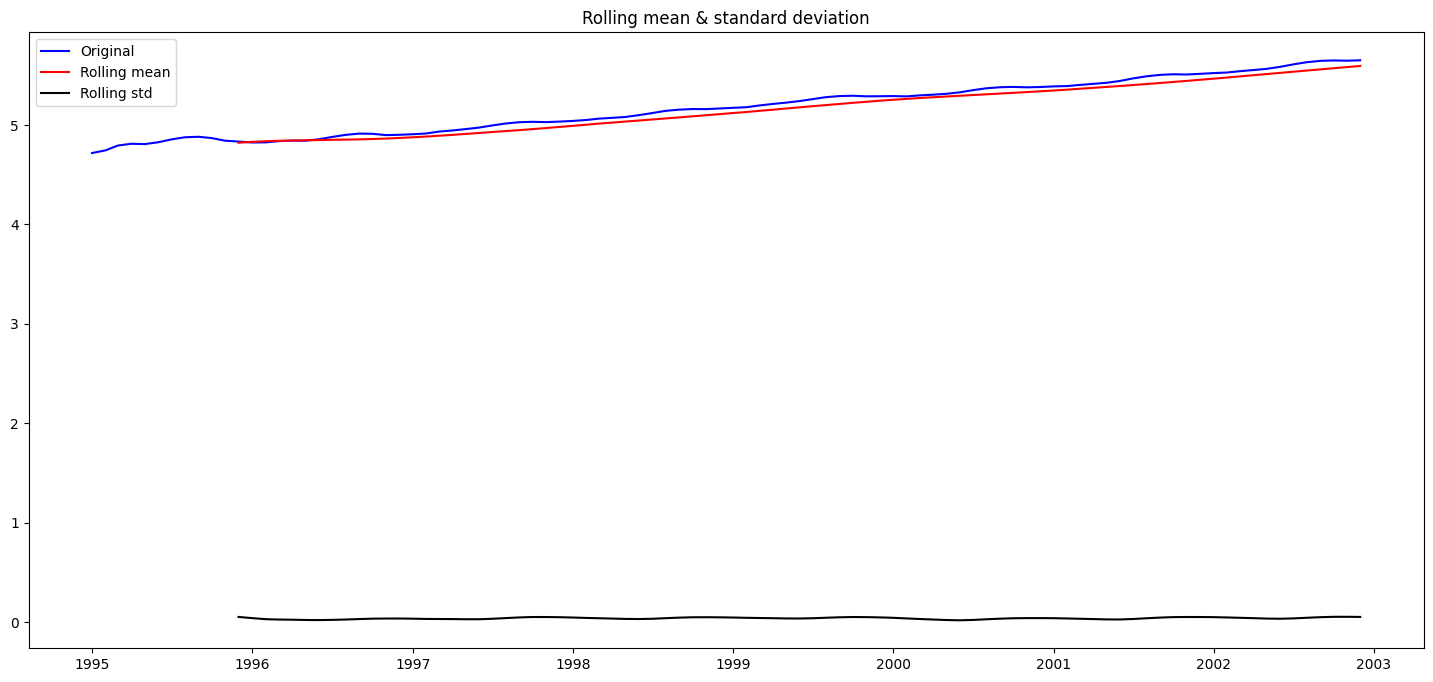

In [44]:
exponentialDecayWeightedAverage = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
roll_mean(exponentialDecayWeightedAverage)

Results of Dickey-Filler Test
Test Statistic                 -2.835036
p-value                         0.053441
#Lags used                     12.000000
Number of Observations Used    83.000000
Critical value (1%)            -3.511712
Critical value (5%)            -2.897048
Critical value (10%)           -2.585713
dtype: float64




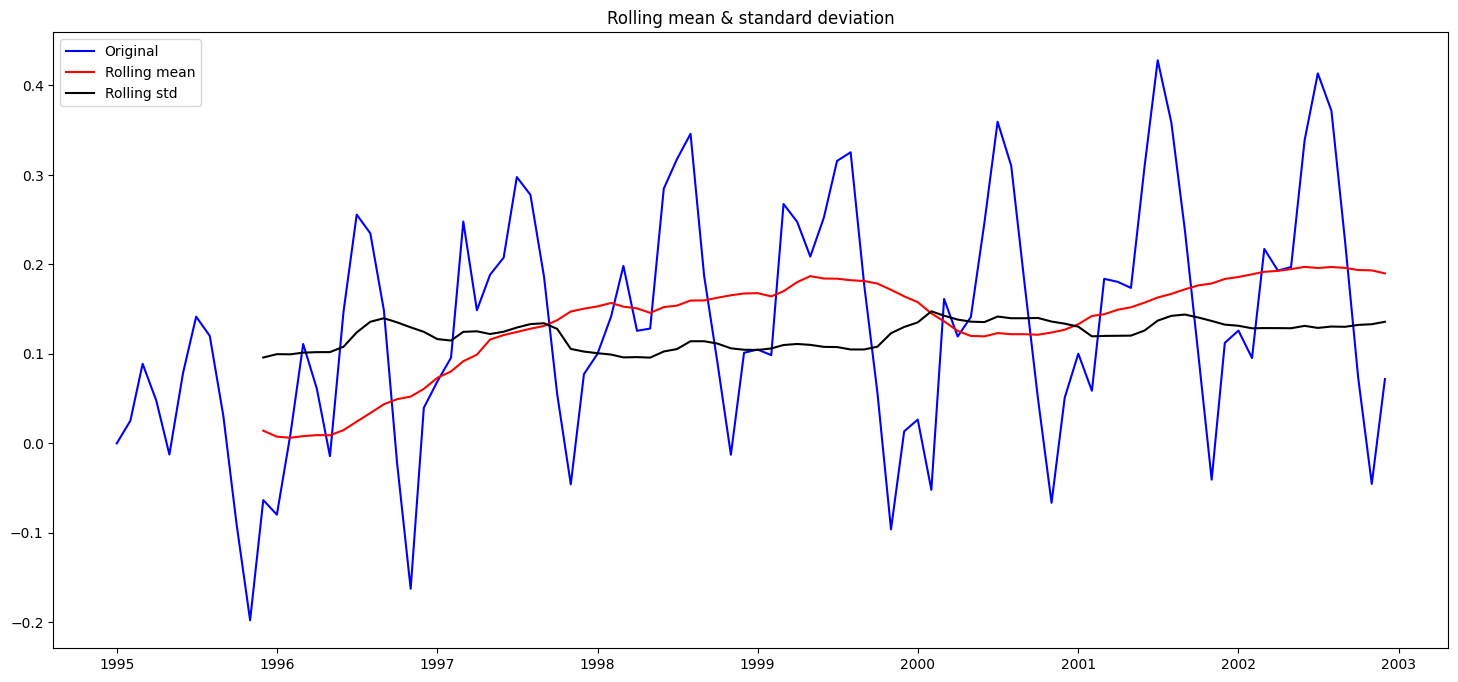

In [45]:
dataLogScaleMinusMovingExponentialDecayAverage = df_log - exponentialDecayWeightedAverage
roll_mean(dataLogScaleMinusMovingExponentialDecayAverage)

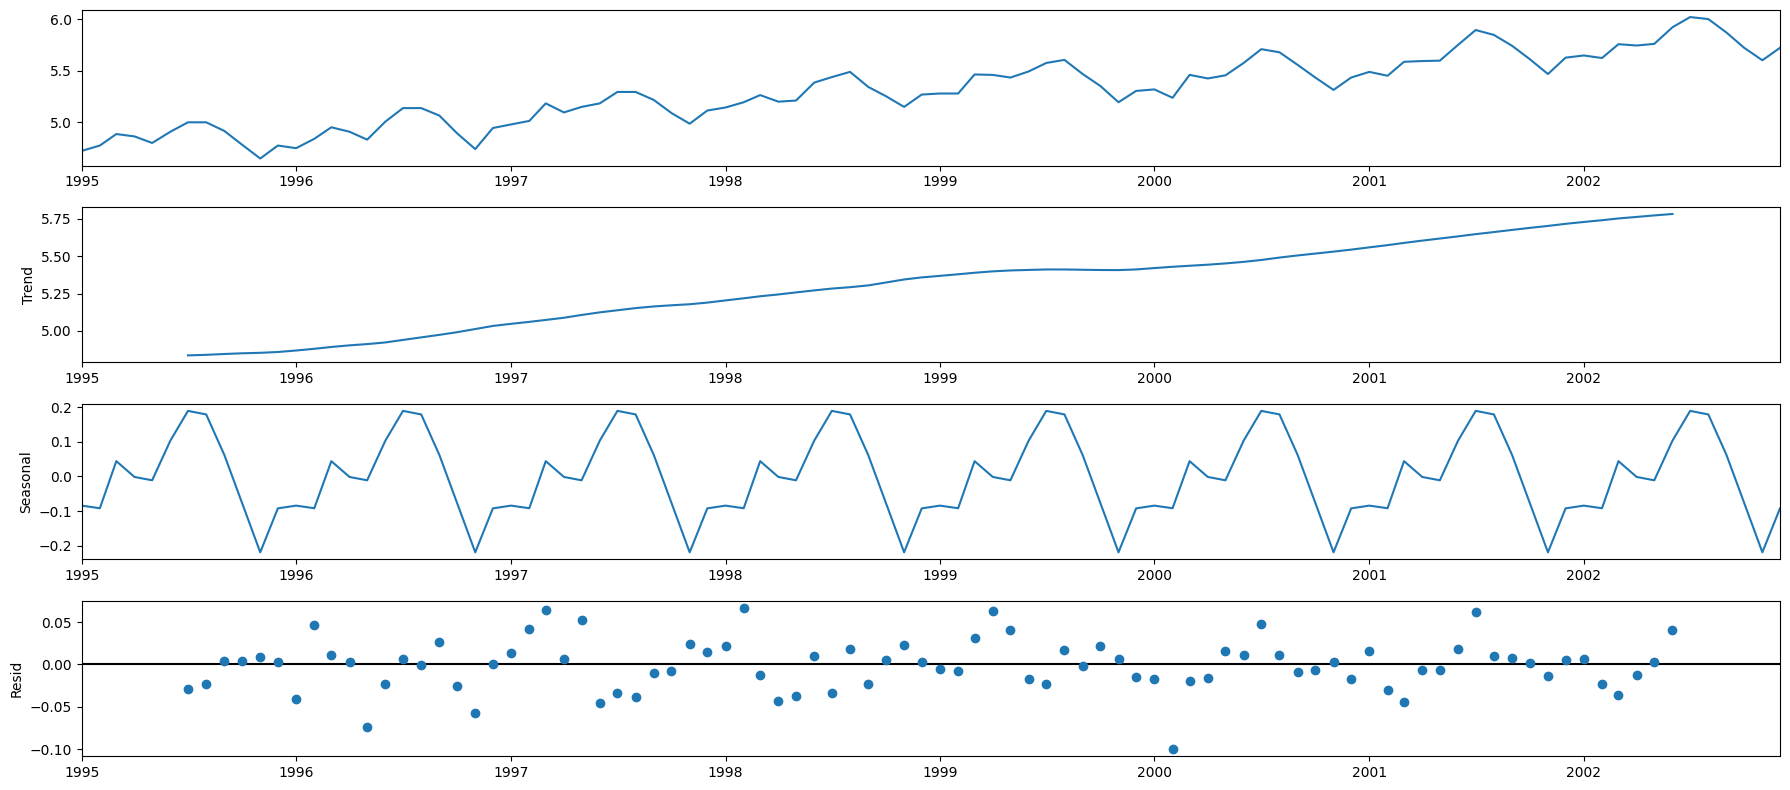

In [48]:
decomposition = sm.tsa.seasonal_decompose(df_log)
decomposition.plot();

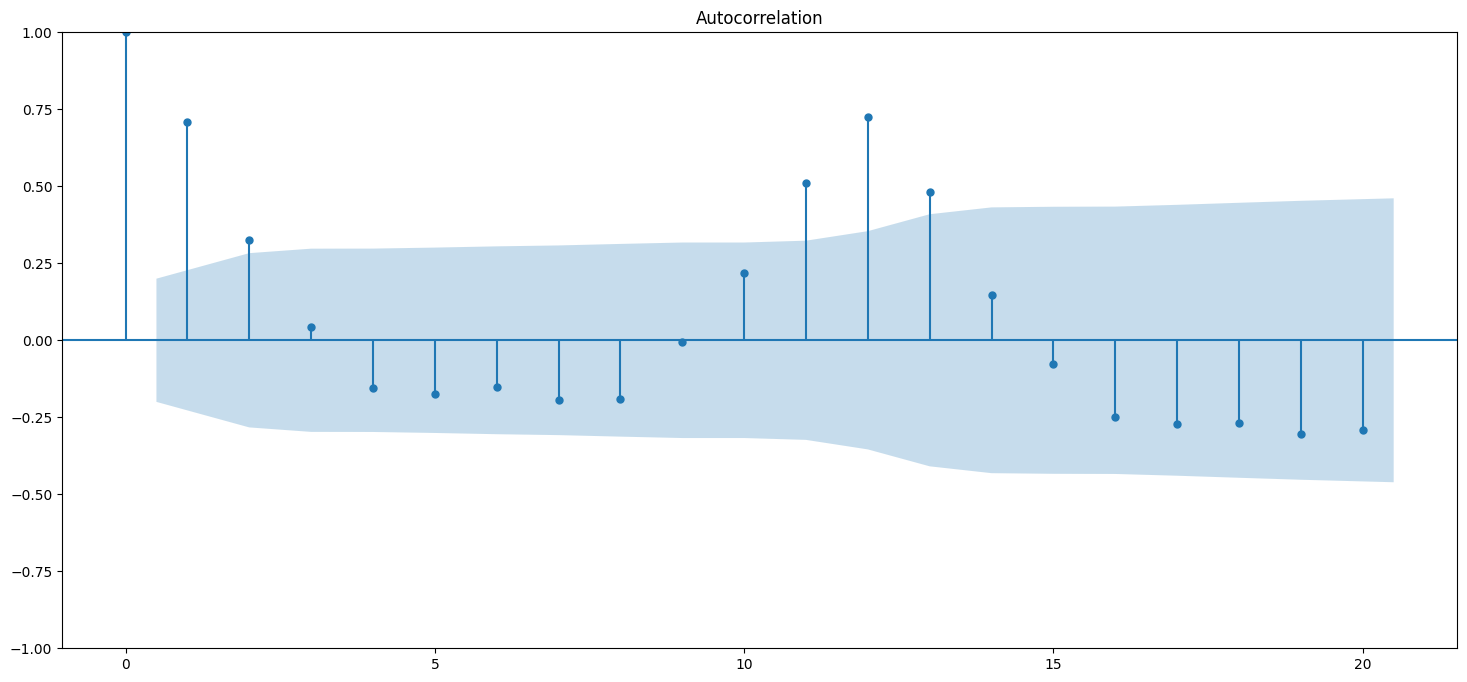

In [60]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(dataLogScaleMinusMovingExponentialDecayAverage,lags=20);


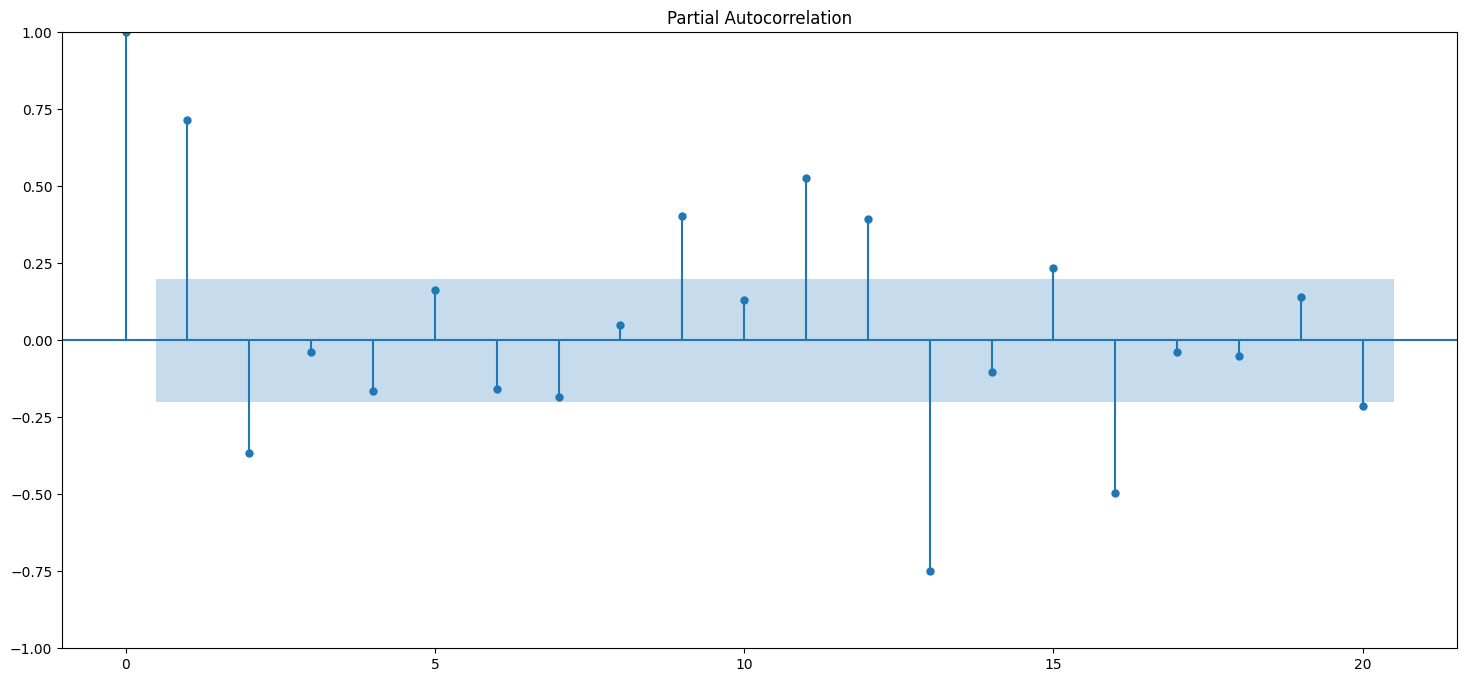

In [61]:
plot_pacf(dataLogScaleMinusMovingExponentialDecayAverage,lags=20);

In [51]:
X_train = df_log.iloc[:84]
X_test = df_log.iloc[84:]

X_test.shape


(12, 1)

**ARIMA Model**

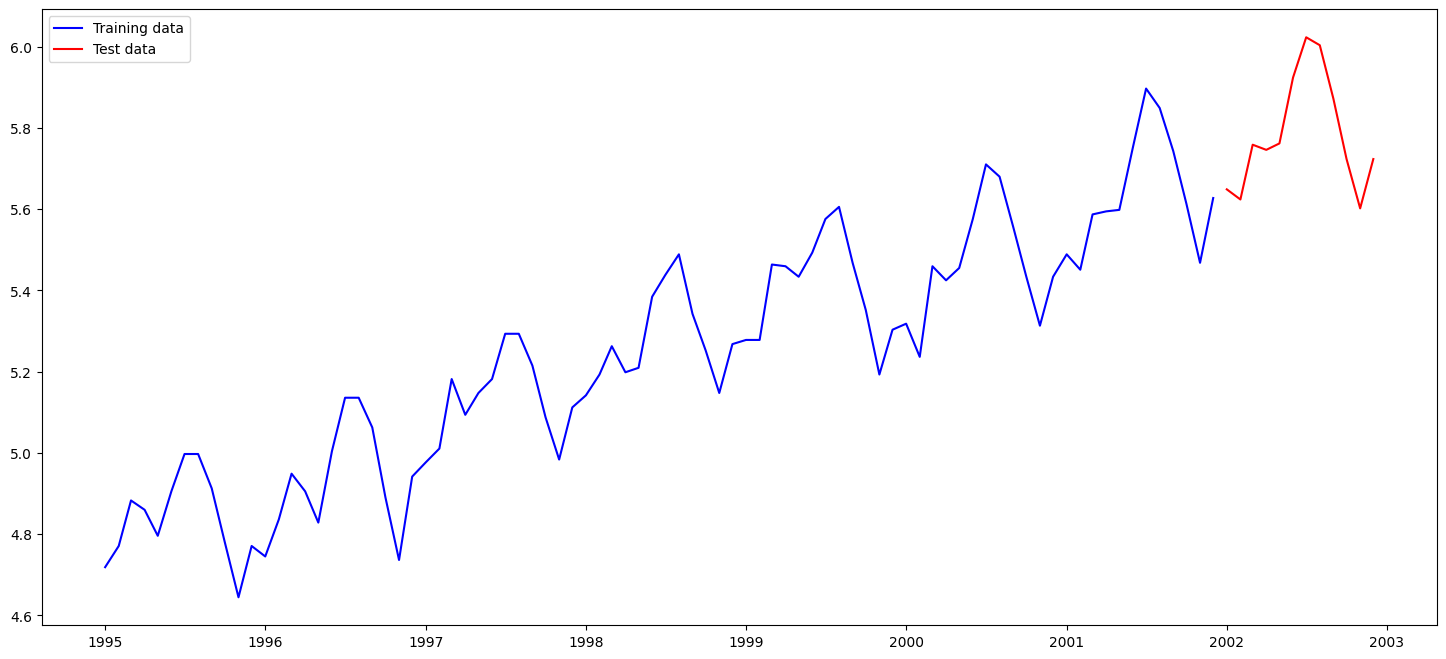

In [52]:
plt.plot(X_train,label='Training data',color='blue')
plt.plot(X_test,label='Test data',color='red')
plt.legend()

In [53]:
from statsmodels.tsa.arima.model import ARIMA

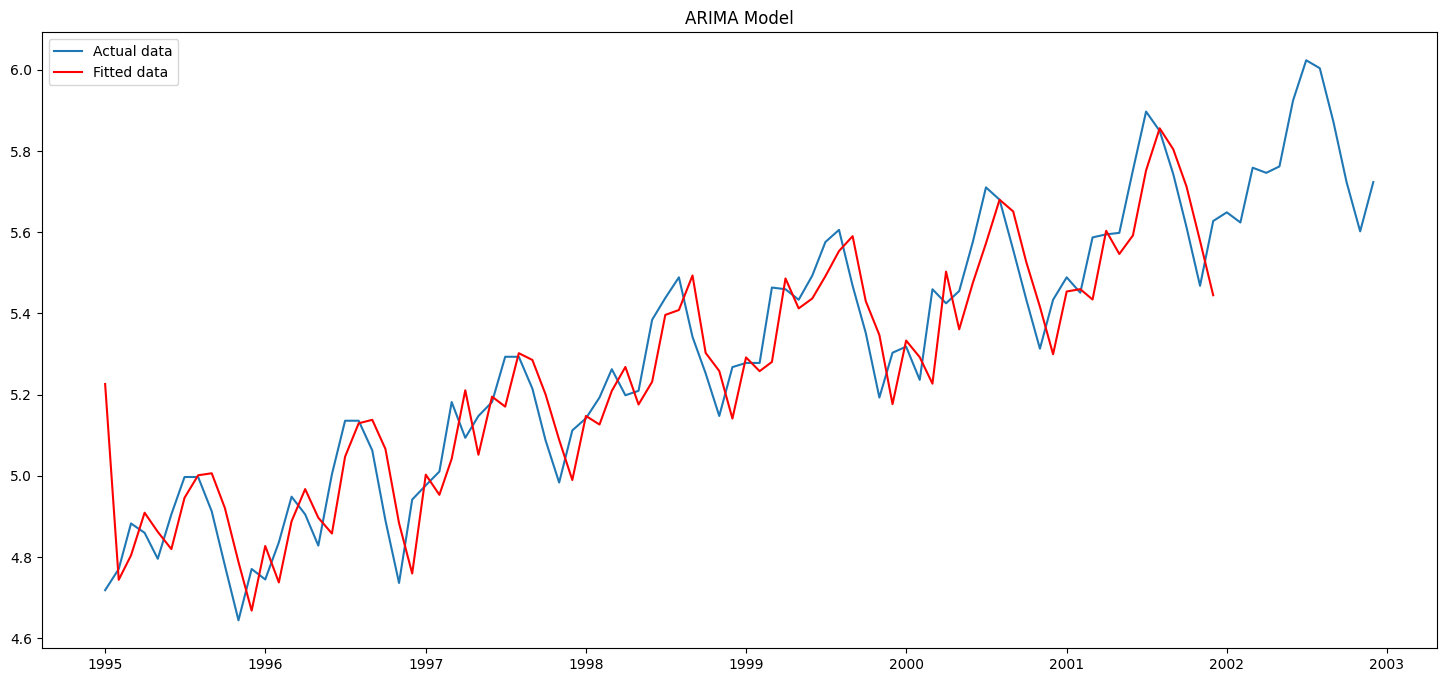

In [54]:
model2 = ARIMA(X_train,order=(3,0,2),freq='MS')
results_ARIMA = model2.fit()

plt.plot(df_log,label='Actual data')
plt.plot(results_ARIMA.fittedvalues,color='red',label='Fitted data')
plt.title('ARIMA Model')
plt.legend()

In [55]:
result1 = results_ARIMA.predict(start=85,end=96)
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(X_test,result1)


0.047564096645734855

In [56]:
result = pd.DataFrame({'test_data':X_test['Passengers']})
result['prediction'] = results_ARIMA.forecast(12)
result


,test_data,prediction
Month,,
2002-01-01,5.648974,5.649385
2002-02-01,5.624018,5.596075
2002-03-01,5.758902,5.578959
2002-04-01,5.746203,5.569736
2002-05-01,5.762051,5.540180
2002-06-01,5.924256,5.526024
2002-07-01,6.023448,5.511077
2002-08-01,6.003887,5.491954
2002-09-01,5.872118,5.478702


In [57]:
# !pip install pmdarima

In [58]:
# from statsmodels.tsa.arima_model import ARIMA

# import pmdarima as pm

# model = pm.auto_arima(df_log, start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0,
#                       D=0,
#                       trace=True,
#                       error_action='ignore',
#                       suppress_warnings=True,
#                       stepwise=True)

# print(model.summary())

<Axes: xlabel='Month'>

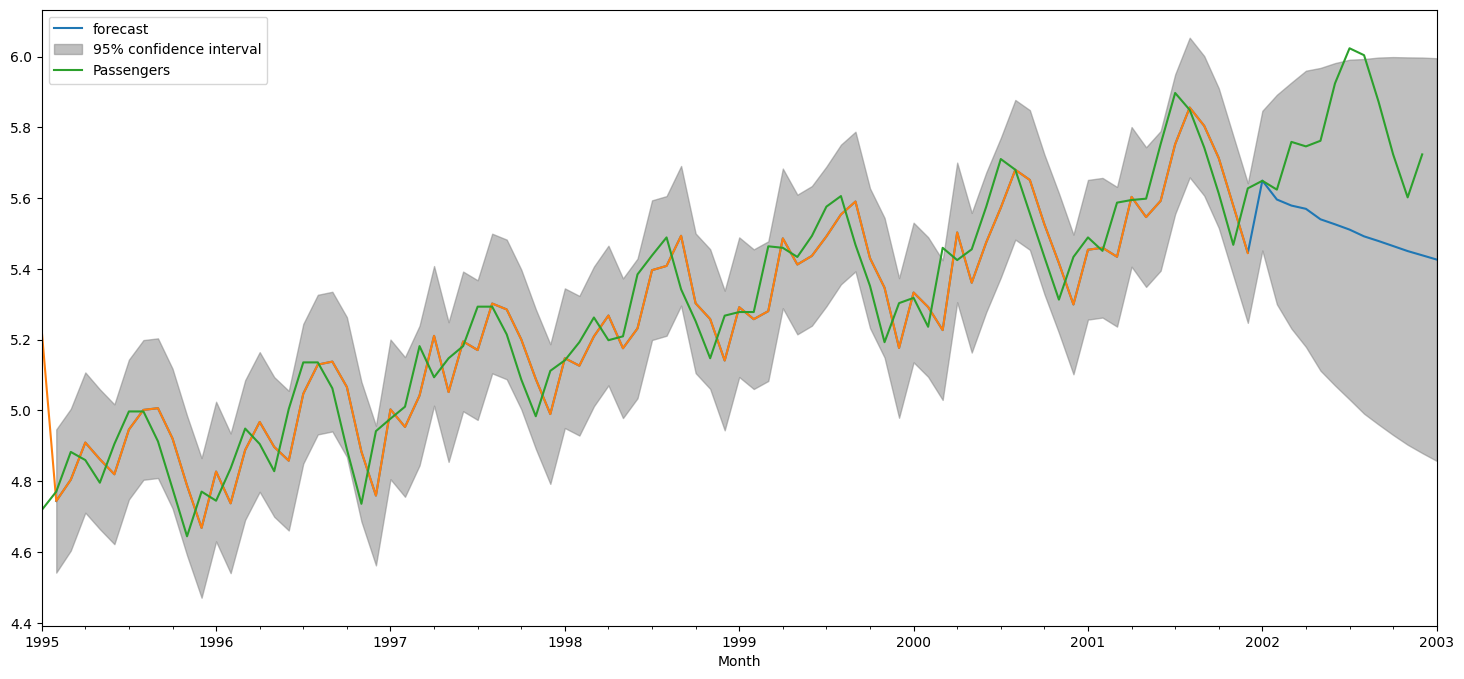

In [62]:
from statsmodels.graphics.tsaplots import plot_predict


plot_predict(results_ARIMA,start=1,end=96);
results_ARIMA.fittedvalues.plot()
df_log['Passengers'].plot(legend=True)